# Data analisys for Path Loss characterization

---


<script
  src="https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML"
  type="text/javascript">
</script>

Import libraries

In [9]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression

## USRP Calibration

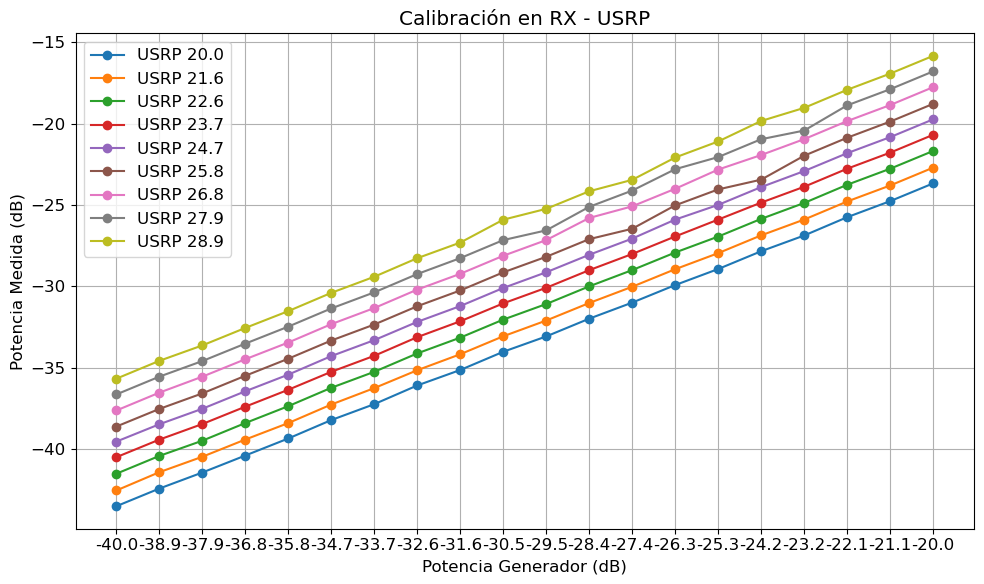

In [10]:
# Step 1: Read the CSV file into columna1 and matrix
file_name = r'..\Data\RX_CAL\USRP01_500.0MHz_15-06-2024-22-00-18.csv'
matrix = []
columna1 = []
fila = []

with open(file_name, mode='r') as file:
    reader = csv.reader(file)

    # Iterar sobre cada fila en el archivo CSV
    for idx, row in enumerate(reader):
        if idx == 0:
            # Omitir la primera fila para agregar solo a columna1
            continue
        if idx == 1:  # Si es la segunda fila (índice 1 en base 0)
            fila = row  # Guardar la segunda fila en la lista fila
            # break       # Terminar el bucle después de leer la segunda fila

        # Agregar desde la segunda columna hasta el final a la matriz
        # Convertir valores a float
        matrix.append([float(val) for val in row[1:]])

        # Agregar el primer elemento de cada fila a columna1
        columna1.append(row[0])

# Step 2: Remove the first row from matrix (if exists)
if matrix:
    matrix.pop(0)  # Eliminar la primera fila de la matriz

if columna1:
    columna1.pop(0)  # Eliminar el primer elemento de columna1

if fila:
    fila.pop(0)


for idx, data_row in enumerate(matrix):

    if len(fila) != len(data_row):
        print(f"Error: Los tamaños de fila y data_row no coinciden para la fila ")
        print(len(data_row))
        continue

    # Crear una nueva figura para cada fila de matrix
    plt.plot(fila, data_row, marker='o', label=f'USRP {columna1[idx]}')

# Añadir título y etiquetas
plt.title('Calibración en RX - USRP')
plt.xlabel('Potencia Generador (dB)')
plt.ylabel('Potencia Medida (dB)')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Mostrar la gráfica
plt.show()

## GPS calibration 2D

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


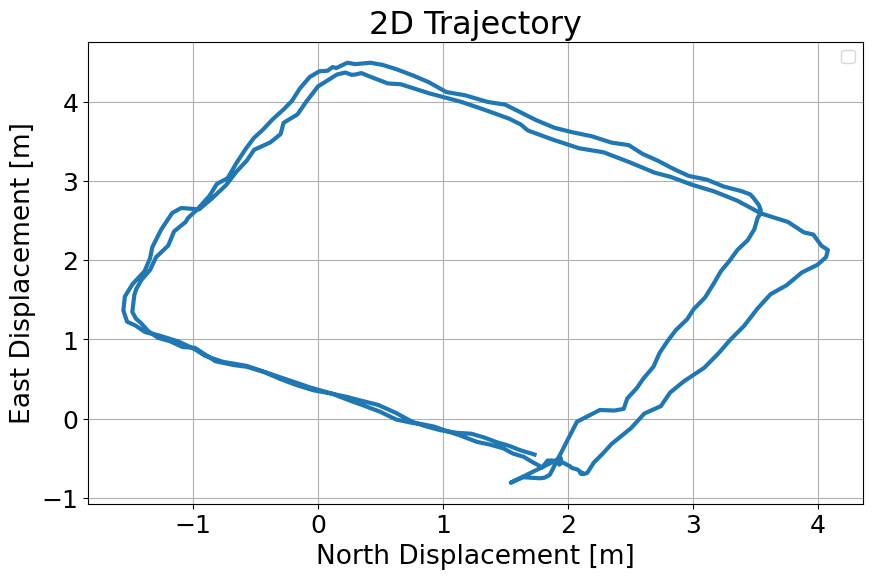

In [11]:
# Leer el archivo CSV
# Reemplaza con la ruta a tu archivo
file_path = '..\Data\Meas_GPS\GPS_MEAS_30-07-2024-16-25-35.csv'
df = pd.read_csv(file_path)
# Filtrar filas donde latitud, longitud y altitud son todas 0
absPos = df[df['pos_type'] == 'absPos']
relPos = df[df['pos_type'] == 'relPos']
# Supongamos que las columnas se llaman 'Latitud', 'Longitud' y 'Altitud'
latitudes = absPos['pos2']
longitudes = absPos['pos1']
altitudes = absPos['pos3']
disN = relPos['pos1']
disE = relPos['pos2']
disD = relPos['pos3']

initial_point = np.array([-74.0827278, 4.6388707, 2589131])

# Calcular las distancias desde el punto inicial
distances = np.sqrt((latitudes - initial_point[0])**2 +
                    (longitudes - initial_point[1])**2 +
                    (altitudes - initial_point[2])**2)


# Graficar el recorrido en 2D
plt.figure()
plt.plot(disN, disE, linewidth=3)
plt.xlabel('North Displacement [m]', fontsize=19)
plt.ylabel('East Displacement [m]', fontsize=19)
plt.title('2D Trajectory', fontsize=23)
plt.legend()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# Mostrar la gráfica
plt.show()

## GPS calibration 3D

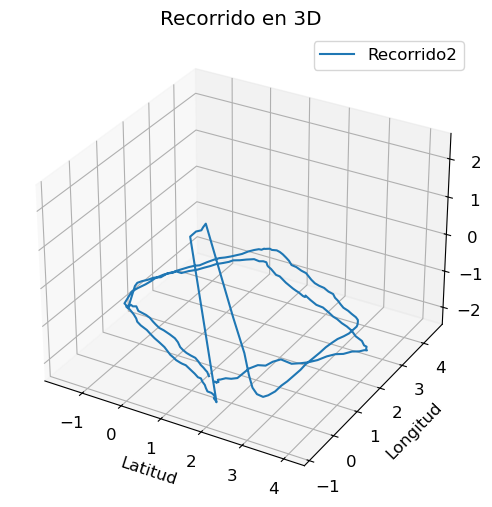

In [12]:
# Graficar el recorrido en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.plot(latitudes, longitudes, altitudes, label='Recorrido1')
ax.plot(disN, disE, disD, label='Recorrido2')
ax.set_xlabel('Latitud')
ax.set_ylabel('Longitud')
ax.set_zlabel('Altitud')
ax.set_title('Recorrido en 3D')
ax.legend()

## Beamwidth Measurement

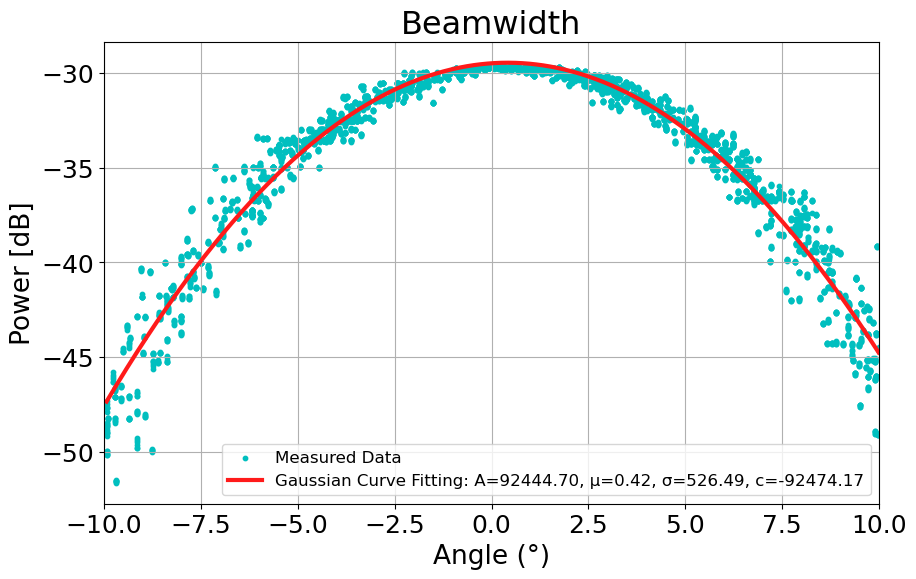

In [13]:
# Leer el archivo CSV
CSV = pd.read_csv(r'..\Data\BeamWidth\USRP01_BW_MEAS_19-07-2024-17-32-56.csv')

# Verificar si las columnas necesarias existen
if 'MAG' not in CSV.columns or 'PowerRx' not in CSV.columns:
    raise ValueError('El archivo CSV no contiene las columnas necesarias: MAG, PowerRx')

# Extraer las columnas en listas
AngleAci = np.array(CSV['MAG'])
Power = np.array(CSV['PowerRx'])

# Ajustar los ángulos
AngleAci_adjusted = np.where(AngleAci > 180, AngleAci - 360, AngleAci)

# Verificar si el array de Potencia está vacío
if len(Power) == 0:
    raise ValueError('El array de Potencia está vacío')

# Encontrar el valor máximo para el ajuste del ángulo
max_value = CSV.loc[CSV['PowerRx'].idxmax()]
Center = AngleAci_adjusted - max_value['MAG']

# Filtrar valores NaN e Inf
valid_indices = np.isfinite(Center) & np.isfinite(Power)
Center = Center[valid_indices]
Power = Power[valid_indices]

# Filtrar los valores de Center entre -10 y 10
filter_mask = (Center >= -10) & (Center <= 10)
Center_filtered = Center[filter_mask]
Power_filtered = Power[filter_mask]

# Verificar si los arrays filtrados están vacíos
if len(Center_filtered) == 0 or len(Power_filtered) == 0:
    raise ValueError('Los arrays filtrados están vacíos después de aplicar el límite.')

# Definir la función gaussiana
def gaussian(x, A, mu, sigma, const):
    return A * np.exp(- (x - mu)**2 / (2 * sigma**2)) + const

# Ajustar los parámetros iniciales
initial_guess = [max(Power_filtered), 0, 1, min(Power_filtered)]  # [A, mu, sigma, const]

# Ajustar la curva solo con los datos filtrados
try:
    popt, pcov = curve_fit(gaussian, Center_filtered, Power_filtered, p0=initial_guess, maxfev=10000)
except RuntimeError as e:
    print(f"Error: {e}")
    raise

# Extraer los parámetros ajustados
A, mu, sigma, const = popt

# Generar los valores x para la línea ajustada
x_fit = np.linspace(min(Center_filtered), max(Center_filtered), 1000)
y_fit = gaussian(x_fit, *popt)
plt.xlim(-10, 10)
# Graficar los datos filtrados y el ajuste gaussiano
plt.scatter(Center_filtered, Power_filtered, color='c', label='Measured Data',s=10)
plt.plot(x_fit, y_fit, color='#FF1A1A', label=f'Gaussian Curve Fitting: A={A:.2f}, μ={mu:.2f}, σ={sigma:.2f}, c={const:.2f}', linewidth=3)
plt.title('Beamwidth',fontsize=23)
plt.xlabel('Angle (°)',fontsize=19)
plt.ylabel('Power [dB]',fontsize=19)
plt.legend(fontsize=18)  # Ajusta el tamaño de la fuente de las etiquetas de la gráfica
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend()
plt.show()


## Free space

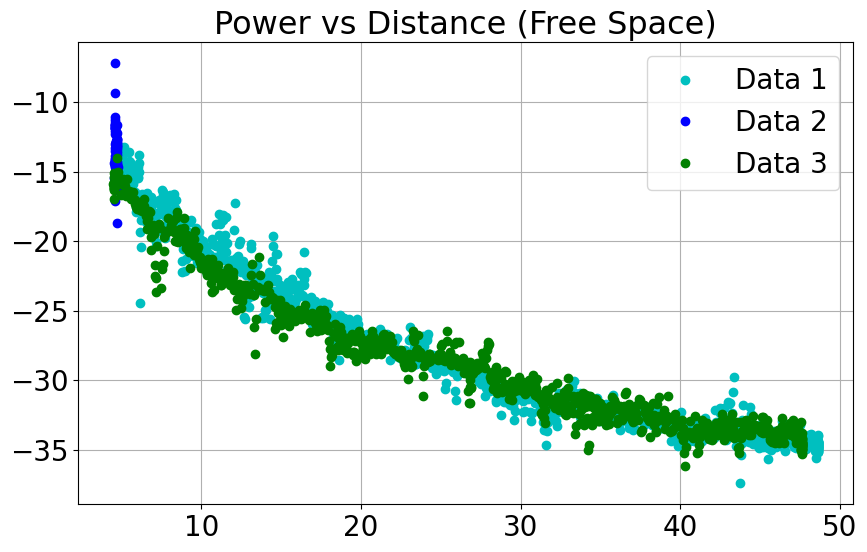

In [14]:

# Función para calcular la distancia Euclidiana para relPos
def calcular_distancia_relPos(df):
    # Convertir altitud a metros
    df['Distance'] = np.sqrt(
        df['R_N/Lon']**2 + df['R_E/Lat']**2 + (df['R_D/Hgt'])**2)
    return df

# Función para ajustar los valores de MAG para que estén dentro de -180 a 180 grados


def adjust_MAG(MAG, reference_MAG):
    adjusted_MAG = MAG - reference_MAG
    adjusted_MAG[adjusted_MAG > 180] -= 360
    adjusted_MAG[adjusted_MAG < -180] += 360
    return adjusted_MAG

# Función para corregir los valores de PowerRx basada en una ecuación proporcionada
def correct_PowerRx(row, beamwidth_func):
    correction = beamwidth_func(0) - beamwidth_func(row['MAG'])
    return row['PowerRx'] + correction

# Función para procesar cada archivo CSV
def procesar_archivo(csv_file, beamwidth_func, distanceB):
    df = pd.read_csv(csv_file)

    # Filtrar datos basados en PosType 'relPos'
    relPos_df = df[df['PosType'] == 'relPos'].copy()

    # Calcular distancias para relPos
    if not relPos_df.empty:
        relPos_df = calcular_distancia_relPos(relPos_df)

        max_power_idx_relPos = relPos_df['PowerRx'].idxmax()
        max_power_relPos = relPos_df.loc[max_power_idx_relPos]

        # Ajustar valores de MAG
        relPos_df['MAG'] = adjust_MAG(
            relPos_df['MAG'], max_power_relPos['MAG'])

        # Filtrar datos por MAG en el rango [-10, 10]
        relPos_df = relPos_df[(relPos_df['MAG'] >= -10)
                              & (relPos_df['MAG'] <= 10)]
        relPos_df = relPos_df[relPos_df['Distance'] > distanceB]

        # Corregir PowerRx basada en la función de ancho de haz
        relPos_df['PowerRx'] = relPos_df.apply(
            correct_PowerRx, axis=1, beamwidth_func=beamwidth_func)

        # Ordenar por distancia y PowerRx
        relPos_df = relPos_df.sort_values(
            by=['Distance', 'PowerRx'], ascending=[True, False])

        # Calcular la mediana de PowerRx para cada distancia
        relPos_df = relPos_df.groupby(
            'Distance')['PowerRx'].median().reset_index()

    return relPos_df


# Listado de archivos CSV
archivos_csv = [
    r'..\Data\5G_loss\5G_loss_MEAS_01-08-2024\5G_loss_MEAS_01-08-2024-12-58-35.csv',
    r'..\Data\5G_loss\5G_loss_MEAS_01-08-2024\5G_loss_MEAS_01-08-2024-13-03-11.csv',
    r'..\Data\5G_loss\5G_loss_MEAS_01-08-2024\5G_loss_MEAS_01-08-2024-13-10-13.csv'
]

# Definir la función de ancho de haz


def beamwidth_func(MAG): return 133800.55 * np.exp(- (MAG - 0.42)
                                                   ** 2 / (2 * 633.4**2))  # Función de ejemplo


# Colores para diferenciar cada archivo en la gráfica
colores = ['c', 'b', 'g', 'r', 'm', 'y']

# Inicializar lista para almacenar resultados
relPos_data = []

# Procesar cada archivo y almacenar los resultados
for i, csv_file in enumerate(archivos_csv):
    relPos_df = procesar_archivo(csv_file, beamwidth_func, 0)
    relPos_data.append((relPos_df, colores[i]))

# Graficar PowerRx en función de la distancia para relPos
plt.figure(figsize=(10, 6))
for i, (relPos_df, color) in enumerate(relPos_data):
    plt.plot(relPos_df['Distance'], relPos_df['PowerRx'], label=f'Data {i+1}', marker='o', color=color, linestyle=' ')

plt.title('Power vs Distance (Free Space)',fontsize=23)
plt.legend(fontsize=20, loc="upper right")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.show()

## Linearization


$$\begin{equation}
    \begin{matrix}
        P_{sig}^{Rx} = \displaystyle\frac{P_{TX}\cdot G_T\cdot G_R \cdot K_{Rx} }{\left(\frac{4\pi R}{\lambda}\right)^2} = \displaystyle\frac{A}{\left(\frac{4\pi R}{\lambda}\right)^2}
    \end{matrix}
\end{equation}
$$

$$
\begin{equation}
    P_{sig}^{Rx} (dB) = 10\log_{10}\left(A \right) - 20\log_{10}\left(4\pi R/\lambda\right)
\end{equation}
$$

$$
\begin{equation}
     \left.P_{sig}^{Rx} (dB)\right|_{R=1m} = 10\log_{10}\left(A \right) - 20\log_{10}\left(4\pi/\lambda\right)
\end{equation}
$$

C:\Users\JuliansCastro\AppData\Local\Temp\ipykernel_2984\708230006.py:111: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  fin = float(x_value[99])


7036854.381741264


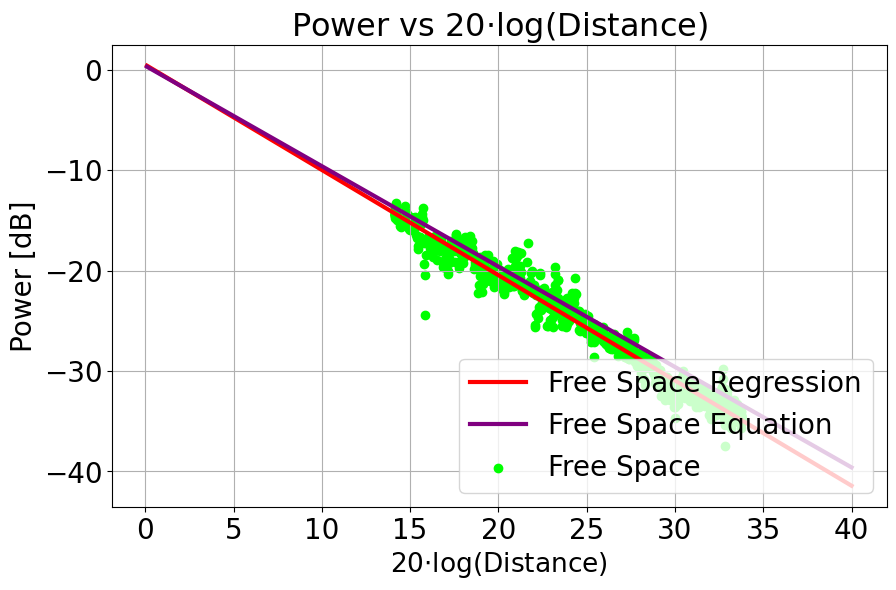

In [15]:
# Función para calcular la distancia Euclidiana para relPos
def calcular_distancia_relPos(df):
    # Convertir altitud a metros
    df['Distance'] = np.sqrt(df['R_N/Lon']**2 + df['R_E/Lat']**2 + (df['R_D/Hgt'])**2)
    return df

# Función para ajustar los valores de MAG para que estén dentro de -180 a 180 grados


def adjust_MAG(MAG, reference_MAG):
    adjusted_MAG = MAG - reference_MAG
    adjusted_MAG[adjusted_MAG > 180] -= 360
    adjusted_MAG[adjusted_MAG < -180] += 360
    return adjusted_MAG

# Función para corregir los valores de PowerRx basada en una ecuación proporcionada


def correct_PowerRx(row, beamwidth_func):
    correction = beamwidth_func(0) - beamwidth_func(row['MAG'])
    return row['PowerRx'] + correction

# Función para procesar cada archivo CSV


def procesar_archivo(csv_file, beamwidth_func, distanceB):
    df = pd.read_csv(csv_file)

    # Filtrar datos basados en PosType 'relPos'
    relPos_df = df[df['PosType'] == 'relPos'].copy()

    # Calcular distancias para relPos
    if not relPos_df.empty:
        relPos_df = calcular_distancia_relPos(relPos_df)

        max_power_idx_relPos = relPos_df['PowerRx'].idxmax()
        max_power_relPos = relPos_df.loc[max_power_idx_relPos]

        # Ajustar valores de MAG
        relPos_df['MAG'] = adjust_MAG(
            relPos_df['MAG'], max_power_relPos['MAG'])

        # Filtrar datos por MAG en el rango [-10, 10]
        relPos_df = relPos_df[(relPos_df['MAG'] >= -10)
                              & (relPos_df['MAG'] <= 10)]
        relPos_df = relPos_df[relPos_df['Distance'] > distanceB]

        # Corregir PowerRx basada en la función de ancho de haz
        relPos_df['PowerRx'] = relPos_df.apply(
            correct_PowerRx, axis=1, beamwidth_func=beamwidth_func)

        # Ordenar por distancia y PowerRx
        relPos_df = relPos_df.sort_values(
            by=['Distance', 'PowerRx'], ascending=[True, False])

        # Calcular la mediana de PowerRx para cada distancia
        relPos_df = relPos_df.groupby(
            'Distance')['PowerRx'].median().reset_index()

    return relPos_df


# Listado de archivos CSV
archivos_csv = [
    r'..\Data\5G_loss\5G_loss_MEAS_01-08-2024\5G_loss_MEAS_01-08-2024-12-58-35.csv',
    # r'..\Data\5G_loss\5G_loss_MEAS_01-08-2024\5G_loss_MEAS_01-08-2024-13-03-11.csv',
    # r'..\Data\5G_loss\5G_loss_MEAS_01-08-2024\5G_loss_MEAS_01-08-2024-13-10-13.csv'
]


# Definir la función de ancho de haz


def beamwidth_func(MAG): return 133800.55 * np.exp(- (MAG - 0.42)** 2 / (2 * 633.4**2))  # Función de ejemplo


# Colores para diferenciar cada archivo en la gráfica
colores = ['c', 'b', 'g', 'r', 'm', 'y']

# Inicializar lista para almacenar resultados
relPos_data = []

# Procesar cada archivo y almacenar los resultados
for i, csv_file in enumerate(archivos_csv):
    relPos_df = procesar_archivo(csv_file, beamwidth_func, 0)
    relPos_data.append((relPos_df, colores[i]))

# Graficar PowerRx en función de la distancia para relPos
plt.figure(figsize=(10, 6))
for i, (relPos_df, color) in enumerate(relPos_data):
    # Convertir distancia a logaritmo
    log_distance = 20 * np.log10(relPos_df['Distance']).values.reshape(-1, 1)

    # Crear un rango de valores logarítmicos para la predicción
    x_value = np.linspace(0.1, 40, 20000).reshape(-1, 1)

    # Ajustar el modelo de regresión lineal
    model = LinearRegression()
    model.fit(log_distance, relPos_df['PowerRx'])
    model.get_params()

    # Predecir valores de PowerRx
    y_pred = model.predict(x_value)
    P0 = float(y_pred[0])
    c = 299792458     # En m/s
    fc = 60.48e9  # en Hz
    wlenght = c/fc   # Lambda
    A = 10**((P0+20*np.log10(4*np.pi/wlenght))/10)
    P = 10*np.log10(A)-20*np.log10(4*np.pi/wlenght)-x_value
    Pf = float(y_pred[99])
    fin = float(x_value[99])
    print(A)

    plt.plot(x_value, y_pred, label=f'Free Space Regression', color='r',linewidth=3) #LogLog Fig8
    plt.plot(x_value, P, label=f'Free Space Equation', color='#800080', linewidth=3) #LogLog fig8
    plt.scatter(log_distance, relPos_df['PowerRx'], label=f'Free Space', marker='o', color='#00FF00') #LogLog Fig8



def Power_Losses(x, alpha):  # Function of signal Rx Power with losses
    return 10*np.log10(A/((4*np.pi*10**(x/20)/wlenght)**2))+10*np.log10(np.e**(-2*alpha*10**(x/20)))

# def PL_InHModel(x, a, b):
#     f_x = a+b*np.log10(x)+20.0*np.log10(fc)
#     return f_x


def PL_InHModel(x, a, b, c):
    f_x = a+b*np.log10(x)+20.0*np.log10((fc*1e-9))+c * \
        ((fc*1e-9)**0.248)*(x**0.588)*0
    return f_x


plt.xlabel('20$\cdot$log(Distance)',fontsize=19)#Fig8
plt.ylabel('Power [dB]',fontsize=20) #Fig8
plt.title('Power vs 20$\cdot$log(Distance)',fontsize=23)# Fig8
# Ajusta el tamaño de la fuente de las etiquetas de la gráfica
plt.legend(fontsize=20, loc="lower right")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.show()

## Path Loss Analyses


C:\Users\JuliansCastro\AppData\Local\Temp\ipykernel_2984\3695816136.py:21: OptimizeWarning: Covariance of the parameters could not be estimated
  a, b = curve_fit(PL_InHModel, CSV_df['Distance'], PL_meas)
C:\Users\JuliansCastro\AppData\Local\Temp\ipykernel_2984\3695816136.py:34: OptimizeWarning: Covariance of the parameters could not be estimated
  a1, b1 = curve_fit(PL_InHModel, CSV1_df['Distance'], PL1_meas)


[-17.22550262  66.59837034   1.        ]


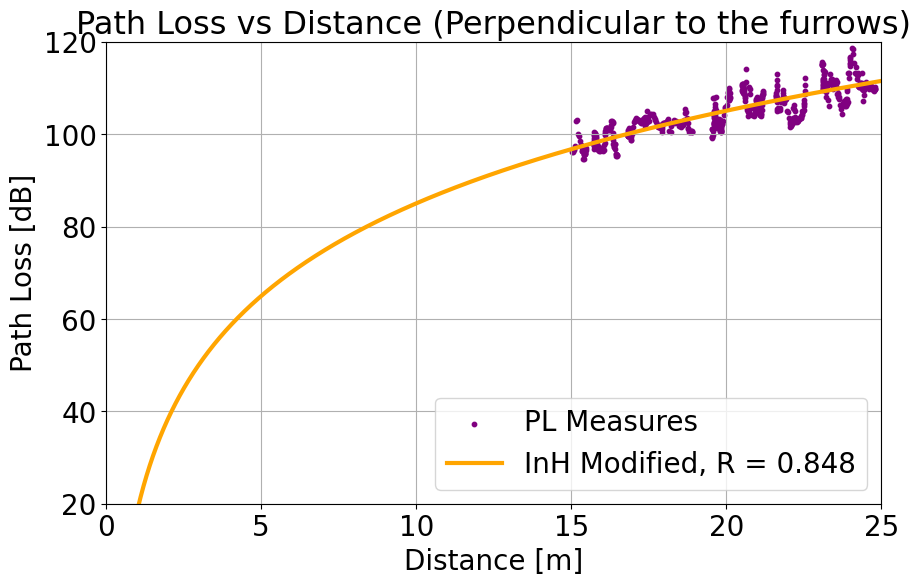

In [16]:
# CSV = r'..\Data/5G_loss/5G_loss_MEAS_20-08-2024-14-23-43.csv'   #Greenhouse 4
CSV = r'..\Data\5G_loss\5G_loss_MEAS_20-08-2024\5G_loss_MEAS_20-08-2024-13-17-20.csv'  # Greenhouse 3
# CSV = r'..\Data\5G_loss\5G_loss_MEAS_08-08-2024\5G_loss_MEAS_08-08-2024-10-53-18.csv' # Greenhouse1
CSV1 = r'..\Data\5G_loss\5G_loss_MEAS_08-08-2024\5G_loss_MEAS_08-08-2024-11-43-57.csv'  # Greenhouse2

CSV_df = procesar_archivo(CSV, beamwidth_func, 15)
CSV1_df = procesar_archivo(CSV1, beamwidth_func, 0)

PL_meas = 1-(CSV_df['PowerRx']-10*np.log10(A))

CSV_log = 20 * np.log10(CSV_df['Distance'])
alpha, a_var = curve_fit(Power_Losses, CSV_log, CSV_df['PowerRx'].values)
x_value = np.linspace(0.1, 40, 20000)
PL = 1-10*np.log10((np.e**(-2*alpha*x_value)) /
                   (4*np.pi*x_value/wlenght)**2)  # Path Loss custom model

PL1 = 1-10 * \
    np.log10((np.e**(-2*alpha*CSV_df['Distance'])) /
             (4*np.pi*CSV_df['Distance']/wlenght)**2)

a, b = curve_fit(PL_InHModel, CSV_df['Distance'], PL_meas)
print(a)
correlation = np.corrcoef(PL_meas, PL_InHModel(
    CSV_df['Distance'], a[0], a[1], a[2]))[0, 1]
correlation = round(correlation, 3)

###

PL1_meas = 1-(CSV1_df['PowerRx']-10*np.log10(A))

CSV1_log = 20 * np.log10(CSV1_df['Distance'])
alpha1, a_var1 = curve_fit(Power_Losses, CSV1_log, CSV1_df['PowerRx'].values)

a1, b1 = curve_fit(PL_InHModel, CSV1_df['Distance'], PL1_meas)
correlation1 = np.corrcoef(PL1_meas, PL_InHModel(
    CSV1_df['Distance'], a1[0], a1[1], a1[2]))[0, 1]
correlation1 = round(correlation1, 3)

plt.figure(figsize=(10, 6))

plt.xlim(0, 25)  # Reemplaza min_x y max_x con los valores deseados
plt.ylim(20, 120)  # Reemplaza min_y y max_y con los valores deseados

## Perpendicular 

plt.scatter(CSV_df['Distance'], PL_meas, label=f'PL Measures', color='#800080', s=10)
plt.plot(x_value, PL_InHModel(x_value, a[0], a[1], a[2]), label=f'InH Modified, R = {correlation}', color='#FFA500', linewidth=3)  # 3GPP base model

## Paralelo

# plt.scatter(CSV_df['Distance'], PL_meas,label=f'Measures with metal structrue', color='#66CC66', s=10)
# plt.plot(x_value, PL_InHModel(x_value,a[0],a[1], a[2]), label=f'Fitted InH with metal structrue, R = {correlation}', color='#4169E1', linewidth=3) # 3GPP base model
# plt.scatter(CSV1_df['Distance'], PL1_meas,label=f'Measures without metal structure', color='#FFC0CB', s=10)
# plt.plot(x_value, PL_InHModel(x_value,a1[0],a1[1], a1[2]), label=f'Fitted InH without metal structure, R = {correlation1}', color='#DC143C', linewidth=3) # 3GPP base model




plt.xlabel('Distance [m]', fontsize=20)
plt.ylabel('Path Loss [dB]', fontsize=20)

plt.title('Path Loss vs Distance (Perpendicular to the furrows)', fontsize=23)
plt.legend(fontsize=20, loc="lower right")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.show()